<a href="https://colab.research.google.com/github/KuangZheLiu/Ai_Tutorial/blob/main/LocoStall_CNN_Model_r0A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torchvision
from torchvision import models, transforms
from torchsummary import summary

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


In [ ]:
MODEL_PATH = 'model.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


#### Download Dataset

In [ ]:
# Download dataset from GoogleDrive
!pip install --upgrade gdown
# 30GB dataset
!gdown --fuzzy 1GRWma3MvpFCjeCcPGhZ1edPklQ00-TV2 --output "train_224_3t_dataset.zip"

!unzip -q "train_224_3t_dataset.zip"

# https://drive.google.com/file/d/1GRWma3MvpFCjeCcPGhZ1edPklQ00-TV2/view?usp=sharing

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1GRWma3MvpFCjeCcPGhZ1edPklQ00-TV2
From (redirected): https://drive.google.com/uc?id=1GRWma3MvpFCjeCcPGhZ1edPklQ00-TV2&confirm=t&uuid=6b2db5b2-690e-4c69-a714-68adf4dda5c8
To: /content/train_224_3t_dataset.zip
100% 92.6M/92.6M [00:02<00:00, 37.2MB/s]


#### Data Process

0: 福州元祖胡椒餅 PepperBun

1: 老芋仔芋頭酥 TaroCrisp

2: 施老闆麻辣臭豆腐 SpicyTofu

3: 名彭下港臭豆腐 Tofu

4: 阿國滷味 Luwei

5: 連家清燉豬腳 PigKnuckle

6: 古早味寶寶麻糬 Machi

7: 紅燒麵牛雜湯 BeefNoodles

8: 東發號麵線油飯肉羹 Noodles

9: 福島屋圓圓燒 MaruYaki


In [ ]:
IMG_SIZE = 224 # 128
# class_names = ['PepperBun', 'TaroCrisp', 'SpicyTofu', 'Tofu', 'Luwei', 'PigKnuckle', 'Machi', 'BeefNoodles', 'Noodles', 'MaruYaki']
class_names = ['PepperBun', 'TaroCrisp', 'SpicyTofu', ]
class_map = {name: i for i, name in enumerate(class_names)}
print(class_map)
NUM_CLASS = len(class_names)

{'PepperBun': 0, 'TaroCrisp': 1, 'SpicyTofu': 2}


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# search .bmp file paths
paths = glob("./content/drive/MyDrive/Train/TrainData_224_3t/*.png")
print("number of samples", len(paths))

number of samples 900


#### Dataset & Dataloader


*   [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)



*   Must implement

    1.   **\_\_len\_\_()**: size of dataset
    2.   **\_\_getitem\_\_()**: load a data sample for a given index

*   \_\_getitem\_\_() steps:
    1. Get image path
    2. Read image, resize
    3. Real image label
    4. convert image to tesnor and rescale to 0~1


ref: [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
class ShopDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, img_size, cls_map, transform):
        self.img_paths = img_paths
        self.img_size = img_size
        self.cls_map = cls_map
        self.transform = transform

    def __len__(self):
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Read img
        path = self.img_paths[idx] # get img path
        img = Image.open(path).convert('RGB')

        # transform img
        img = self.transform(img)

        # Read class index
        cls_name = path.split('/')[-1].split('_')[0]
        # cls_name = path.split('/')[-1]
        cls_idx = self.cls_map[cls_name]
        cls_idx = torch.tensor(cls_idx, dtype=torch.int64)
        return img, cls_idx

In [ ]:
# split dataset
train_paths, val_paths = train_test_split(paths,
    random_state=556,
    test_size=0.2)

len(train_paths), len(val_paths)

(720, 180)

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# Preprocess Transform
transform =  ResNet50_Weights.DEFAULT.transforms()

# Build Dataset
train_ds = ShopDataset(train_paths, IMG_SIZE, class_map,
                      transform)
val_ds = ShopDataset(val_paths, IMG_SIZE, class_map,
                    transform)

In [ ]:
transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Build dataloader
BS = 32
# BS = 64
train_loader = torch.utils.data.DataLoader(train_ds, BS, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BS)

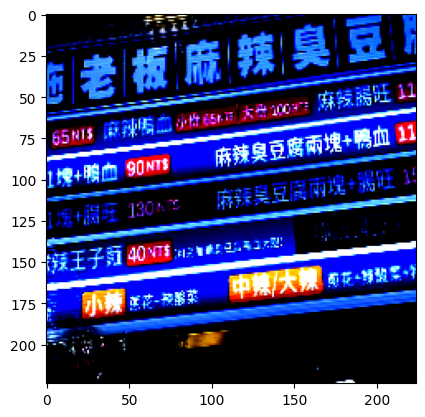

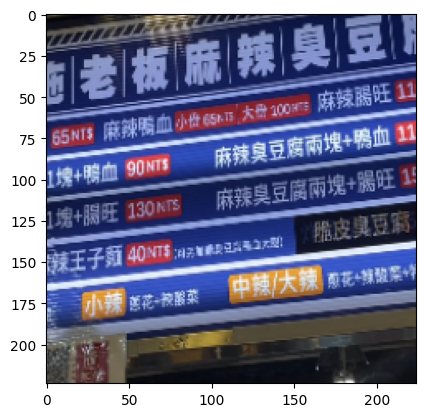

Class: (224, 224, 3)
Class: tensor(2)


In [ ]:
# Visulize sample
idx = np.random.randint(0, len(train_ds))
img, cls = train_ds[idx]

img_normalized = img.permute(1, 2, 0)
plt.imshow(img_normalized)
plt.show()

# Convert back to original value
img_raw = img.numpy().transpose(1, 2, 0) # (3, 256, 256) -> (256, 256, 3)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_raw = std * img_raw + mean
img_raw = np.clip(img_raw, 0, 1)
plt.imshow(img_raw)
plt.show()
print('Class:', img_raw.shape)
print('Class:', cls)

### Build Model

*   [Model List](https://pytorch.org/vision/stable/models.html)

*   Must implement
    1.   **\_\_init\_\_**(): layer **initialization**
    2.   **forward**(): connect **Input** to **Output**



*   Model architecture
    1.   Feature extractor (encoder)
    2.   Flatten
    3.   Classifier

In [ ]:
# # Define Model class
# class CNN(nn.Module):
#     def __init__(self, kernel_size=3):
#         super().__init__()
#         self.feature_extractor = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32,
#                       kernel_size=kernel_size,
#                       padding='same'),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, kernel_size, padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2), # img_size/2

#             nn.Conv2d(32, 64, kernel_size, padding='same'),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size, padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(2), # img_size/4

#             nn.Conv2d(64, 128, kernel_size, padding='same'),
#             nn.ReLU(),
#             nn.Conv2d(128, 128, kernel_size, padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(2), # img_size/8

#             nn.Conv2d(128, 256, kernel_size, padding='same'),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size, padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(2), # img_size/16
#         )
#         self.flatten = nn.Flatten() # (256, 16, 16) -> (256*16*16)
#         self.classifier = nn.Sequential(
#             nn.Linear(256*16*16, 3),
#         )
#     def forward(self, x):
#         x = self.feature_extractor(x) # img to feature maps
#         x = self.flatten(x) # feature maps -> feature vectors
#         x = self.classifier(x) # classification
#         return x

In [ ]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# replace classifier
num_features = model.fc.in_features # len of feature vectors

# # Freeze model
# for param in model.parameters():
#     param.requires_grad = False

# Replace classifier
model.fc = nn.Linear(num_features, NUM_CLASS)
print(model.fc)


Linear(in_features=2048, out_features=3, bias=True)


In [ ]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

#### Training

In [ ]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
def train(pretrained, freeze=False):
    # Model
    if pretrained:
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        model = models.resnet50(weights=None)

    if freeze:
        # Freeze model
        for param in model.parameters():
            param.requires_grad = False # 模型中參數關掉
    # Replace classifier
    num_features = model.fc.in_features # len of feature vectors
    model.fc = nn.Linear(num_features, NUM_CLASS)
    model = model.to(device)

    loss_fn = nn.CrossEntropyLoss()
    # lower learning rate for finetuning
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Earlystopping
    patience = 5
    counter = 0
    best_loss = np.inf
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    EPOCHS = 10
    logs = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
    }
    for epoch in tqdm(range(EPOCHS)):
        train_loss, train_acc = train_epoch(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc = test_epoch(val_loader, model, loss_fn)

        print(f'EPOCH: {epoch:04d} \
        train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
        val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)

        # check improvement
        if val_loss < best_loss:
          counter = 0
          best_loss = val_loss
          torch.save(model.state_dict(), "best.pth")
        else:
          counter += 1
        if counter >= patience:
          print("Earlystop!")
          break

        scheduler.step(val_loss)

    # plot result
    # plt.figure(figsize=(6, 3))
    # plt.subplot(1, 2, 1)
    # plt.title('Loss')
    # plt.plot(logs['train_loss'])
    # plt.plot(logs['val_loss'])
    # plt.subplot(1, 2, 2)
    # plt.title('Acc.')
    # plt.plot(logs['train_acc'])
    # plt.plot(logs['val_acc'])
    # plt.show()

    # Save model
    torch.save(model, MODEL_PATH)



In [ ]:
# train(pretrained=True, freeze=True)
train(pretrained=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH: 0000         train_loss: 0.5274, train_acc: 0.914         val_loss: 0.0678, val_acc: 1.000 


  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH: 0001         train_loss: 0.0330, train_acc: 0.997         val_loss: 0.0111, val_acc: 1.000 


  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH: 0002         train_loss: 0.0054, train_acc: 1.000         val_loss: 0.0061, val_acc: 1.000 


  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH: 0003         train_loss: 0.0024, train_acc: 1.000         val_loss: 0.0049, val_acc: 1.000 


  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH: 0004         train_loss: 0.0021, train_acc: 1.000         val_loss: 0.0042, val_acc: 1.000 


  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH: 0005         train_loss: 0.0013, train_acc: 1.000         val_loss: 0.0036, val_acc: 1.000 


  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH: 0006         train_loss: 0.0030, train_acc: 1.000         val_loss: 0.0051, val_acc: 1.000 


  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH: 0007         train_loss: 0.0011, train_acc: 1.000         val_loss: 0.0042, val_acc: 1.000 


  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH: 0008         train_loss: 0.0017, train_acc: 1.000         val_loss: 0.0037, val_acc: 1.000 


  0%|          | 0/23 [00:00<?, ?it/s]

EPOCH: 0009         train_loss: 0.0011, train_acc: 1.000         val_loss: 0.0017, val_acc: 1.000 


#### Evaluation

In [ ]:
model = model.to(device) # move model to GPU
model.eval() # Set model to evaluation mode
# Create temp tensor
y_true = torch.tensor([], dtype=torch.long).to(device)
y_pred_logits = torch.tensor([]).to(device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        # Concatenate Ground truth and prediction
        y_true = torch.cat((y_true, y), dim=0)
        y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

y_pred_cls = y_pred_logits.argmax(1) # get class idx with max prob (100, 3) -> (100, )
y_pred_probs = nn.Softmax(dim=1)(y_pred_logits) # convert logits to probability

# Move tensor to CPU and convert to np.ndarray
y_true = y_true.cpu().numpy()
y_pred_cls = y_pred_cls.cpu().numpy()
y_pred_probs = y_pred_probs.cpu().numpy()


In [ ]:
# Shape
y_true.shape, y_pred_probs.shape, y_pred_cls.shape

In [ ]:
# calculate ACC
acc = sum(y_true == y_pred_cls) / len(y_true)
acc